In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math
from scipy.spatial.distance import cdist

In [11]:
## starting the dataset

# set the paramters
sigma = 0.5 #variance for the noise

## define the covariance function as the normal GP

def square_exp_kernel(x1, x2, length_scale, output_var):
    hat = (-cdist(x1, x2,metric="euclidean")**2) / (2* length_scale**2)
    exp = np.exp(hat)
    k_se = (output_var**2) * exp
    return k_se

In [13]:
# test the kernel functionx

x_1 = np.random.rand(1, 3)
x_2 = np.random.rand(1, 3)

square_exp_kernel(x_1, x_2, 0.5, 0.5)

array([[0.22817619]])

In [15]:
# define the dataset

n = 100 # test point

x_min = -5
x_max = 5

x_star = np.linspace(x_min*1.4, x_max*1.4, n).reshape(-1,1)

In [19]:
x_star.shape

(100, 1)

In [29]:
#define the cholesky decomp for the matrix inversion of the Covairance matrix


def sample(mean, var, epsilon, N):
    ## generate N samples form the multivariate gaussian
    L = np.linalg.cholesky(var + epsilon*np.eye(var.shape[0]))
    f_post = mean + L @ np.random.normal(size=(n, N))
    return f_post

In [21]:
# define the prior using the kernel matrix

Kxx = square_exp_kernel(x_star, x_star, 1, 1) ## prior covariance

In [43]:
Kxx

array([[1.00000000e+00, 9.90050844e-01, 9.60793360e-01, ...,
        1.38484588e-41, 1.97066866e-42, 2.74878501e-43],
       [9.90050844e-01, 1.00000000e+00, 9.90050844e-01, ...,
        9.53903126e-41, 1.38484588e-41, 1.97066866e-42],
       [9.60793360e-01, 9.90050844e-01, 1.00000000e+00, ...,
        6.44053727e-40, 9.53903126e-41, 1.38484588e-41],
       ...,
       [1.38484588e-41, 9.53903126e-41, 6.44053727e-40, ...,
        1.00000000e+00, 9.90050844e-01, 9.60793360e-01],
       [1.97066866e-42, 1.38484588e-41, 9.53903126e-41, ...,
        9.90050844e-01, 1.00000000e+00, 9.90050844e-01],
       [2.74878501e-43, 1.97066866e-42, 1.38484588e-41, ...,
        9.60793360e-01, 9.90050844e-01, 1.00000000e+00]])

In [31]:
## sample from the prior
jitter = 1e-10
f_prior = sample(0, Kxx, jitter, N=10)


In [47]:
f_prior.shape

(100, 10)

In [41]:
std = np.sqrt(np.diag(Kxx)) ## get the std of each sampling
std

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

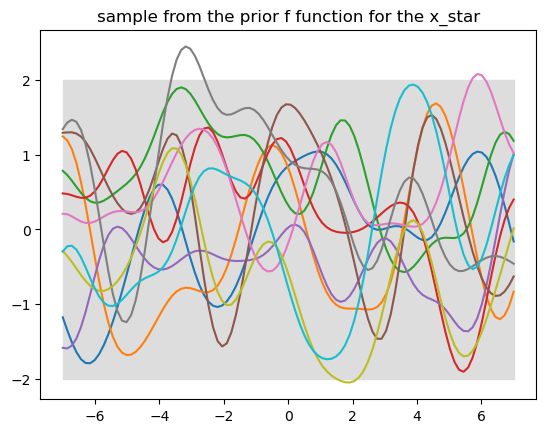

In [45]:
plt.plot(x_star, f_prior)
plt.title("sample from the prior f function for the x_star")
plt.fill_between(x_star.flatten(), 0-2*std, 0+2*std, label = 'std of posterior', color="#dddddd")
plt.legend
                 

<function matplotlib.pyplot.show(close=None, block=None)>

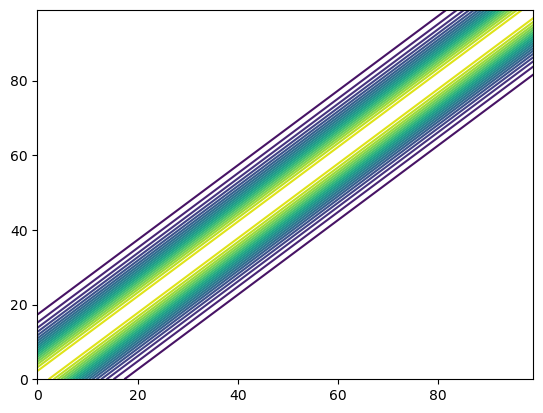

In [67]:
#visualize the covariance matrix
plt.style.use('default')
plt.contour(Kxx, levels=20, cmap='viridis')
plt.show

In [71]:
## now we incoporate some information performing inference by the formular of the normal algorithm

# funciton we want to learn
function = lambda x: np.sin(x) + 0.1 * np.cos(2*x)

In [73]:
#generate the data for simulation
N = 10 #number training point

x_train = np.random.uniform(x_min, x_max, size=[N, 1])
x_train

array([[-3.42405975],
       [ 0.34424415],
       [ 4.11623077],
       [ 0.2124073 ],
       [-2.49584485],
       [-1.29190624],
       [ 2.51234465],
       [-1.08436168],
       [-4.68914155],
       [-3.60770635]])

In [77]:
y_train = function(x_train)
y_train

array([[ 0.3631882 ],
       [ 0.41470601],
       [-0.8644496 ],
       [ 0.30192523],
       [-0.57422749],
       [-1.04620479],
       [ 0.61926181],
       [-0.94029823],
       [ 0.89983786],
       [ 0.50902267]])

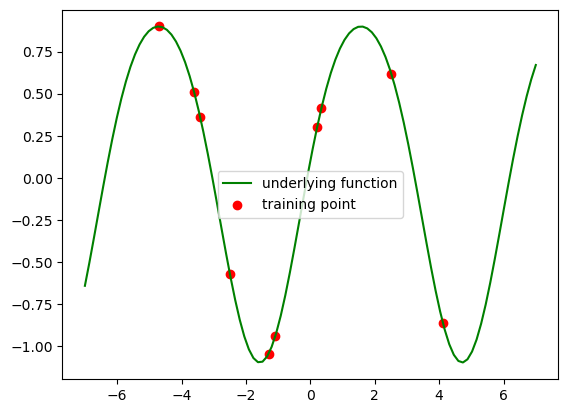

In [83]:
plt.plot(x_star, function(x_star), color="green", label="underlying function")
plt.scatter(x_train, y_train, color="red", label="training point")
plt.legend()
plt.show()

In [85]:
## now we doing the inference by applying the cholesky decomposition to get the mean and covariance matrix after fitting data

def gp_inference(x, y, k, x_star, sigma_f, length):
    Lxx = np.linalg.cholesky(k(x,x,length, sigma_f)) #cholesky decomp for the kernel matrix
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    mu = k(x, x_star, length, sigma_f).T @ a

    # variance
    v = np.linalg.solve(Lxx, k(x, x_star, length, sigma_f))
    var = k(x_star, x_star, length, sigma_f) - v.T @ v

    return mu, var
    

In [109]:
length = 1
sigma_f = 1

# inference
mu, var = gp_inference(x_train, y_train, square_exp_kernel, x_star, sigma_f, length)

In [111]:
mu.shape

(100, 1)

In [113]:
var.shape

(100, 100)

In [123]:
## plot the posterior after fitting and sampling the result

def plot_posterior(x_train, y_train, x_star, mu, var, num_func=10, title="posterior"):
    std = np.sqrt(np.diag(var)) ## getting the std of the posterior
    f_post = sample(mu, var, jitter, N=num_func) # sample function form the posterior

    fig = plt.figure(figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    #ploting the underlying function, train, test and mean
    plt.subplot(2,2,1)
    plt.title(title)
    plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label="std for posterior", color="#dddddd")
    plt.plot(x_star, function(x_star), 'b-', label="ground truth")
    plt.plot(x_star, mu, 'r-', label="mean function")
    plt.scatter(x_train, y_train, color="red", label="training point")
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("sample from GP posterior")
    plt.plot(x_star, f_post)
    plt.scatter(x_train, y_train, color="red", label="training point")
    plt.show()

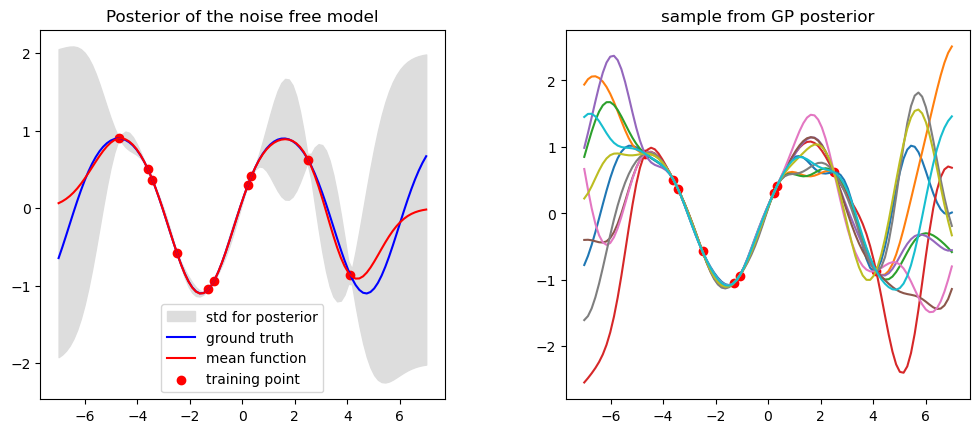

In [125]:
plot_posterior(x_train, y_train, x_star, mu, var, num_func=10, title="Posterior of the noise free model")

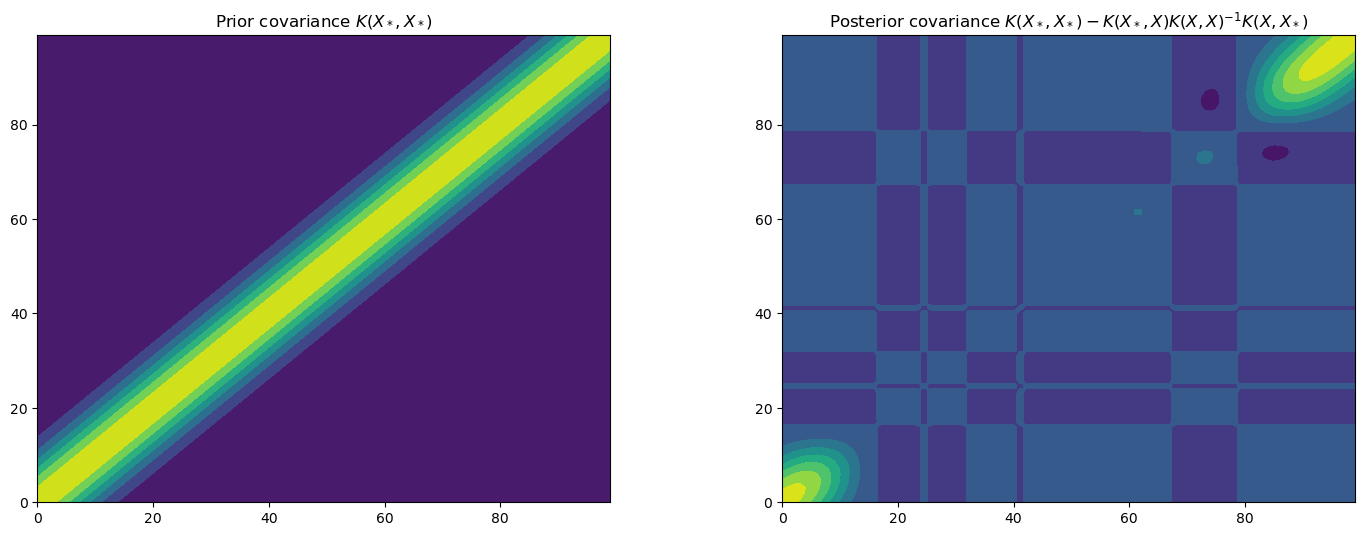

In [129]:
## kernel posterior
k_poster = var

#k_prior
k_prior = Kxx

fig = plt.figure(figsize=(17, 17))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.subplot(2, 2, 1)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(k_prior)

#visualize the covariance matrix
plt.subplot(2, 2, 2)
plt.title("Posterior covariance $K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*)$")
plt.contourf(k_poster)
plt.show()

In [131]:
## this is model for noisy observation

## the ground truth is some how like the function + the gaussian noise

y = lambda x, s: function(x) + np.random.normal(0, np.sqrt(s), x.shape)

<function matplotlib.pyplot.show(close=None, block=None)>

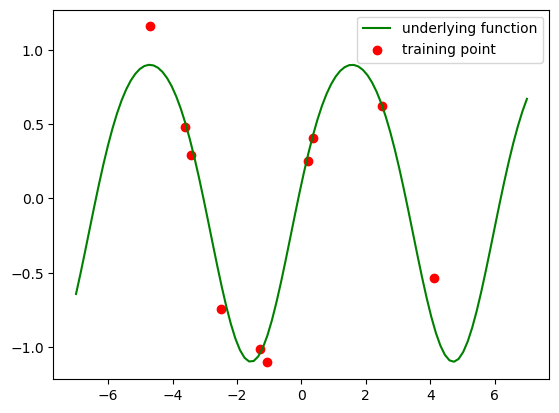

In [133]:
#generate data with the noise var 0.01 

s_n_gen = 0.01
y_train = y(x_train, s_n_gen) #observed target value

#plot the data
plt.plot(x_star, function(x_star), color="green", label="underlying function")
plt.scatter(x_train, y_train, color="red", label="training point")
plt.legend()
plt.show

In [137]:
# now the inferen need to change a little bit

def gp_inference_noise(x, y, k, x_star, sigma_f, sigma_n, length):
    Lxx = np.linalg.cholesky(k(x,x,length, sigma_f) + sigma_n*(np.eye(x.shape[0]))) #cholesky decomp for the kernel matrix
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    mu = k(x, x_star, length, sigma_f).T @ a

    # variance
    v = np.linalg.solve(Lxx, k(x, x_star, length, sigma_f))
    var = k(x_star, x_star, length, sigma_f) - v.T @ v

    return mu, var

In [153]:
length = 1
sigma_f = 1
sigma_n = 0.1

# inference
mu, var = gp_inference_noise(x_train, y_train, square_exp_kernel, x_star, sigma_f, sigma_n, length)

In [155]:
mu.shape

(100, 1)

In [157]:
var.shape

(100, 100)

In [159]:
## plot the posterior after fitting and sampling the result

def plot_posterior(x_train, y_train, x_star, mu, var, num_func=10, title="posterior"):
    std = np.sqrt(np.diag(var)) ## getting the std of the posterior
    f_post = sample(mu, var, jitter, N=num_func) # sample function form the posterior

    fig = plt.figure(figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    #ploting the underlying function, train, test and mean
    plt.subplot(2,2,1)
    plt.title(title)
    plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label="std for posterior", color="#dddddd")
    plt.plot(x_star, function(x_star), 'b-', label="ground truth")
    plt.plot(x_star, mu, 'r-', label="mean function")
    plt.scatter(x_train, y_train, color="red", label="training point")
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("sample from GP posterior")
    plt.plot(x_star, f_post)
    plt.scatter(x_train, y_train, color="red", label="training point")
    plt.show()

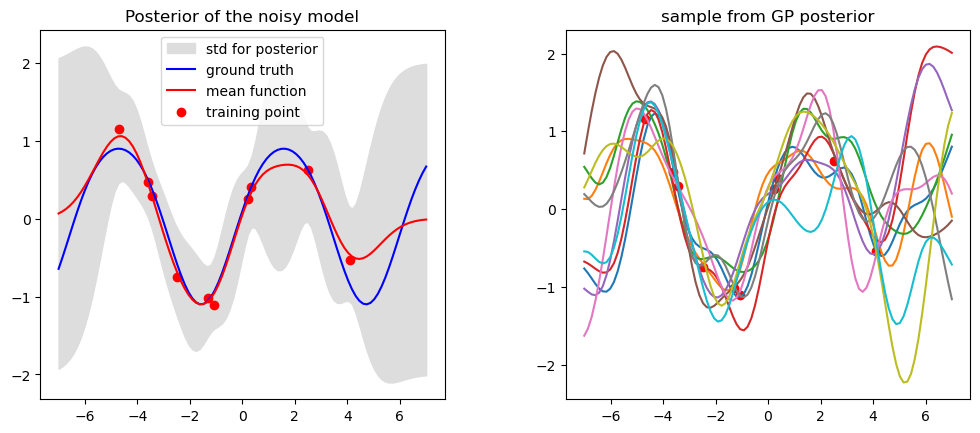

In [161]:
plot_posterior(x_train, y_train, x_star, mu, var, num_func=10, title="Posterior of the noisy model")

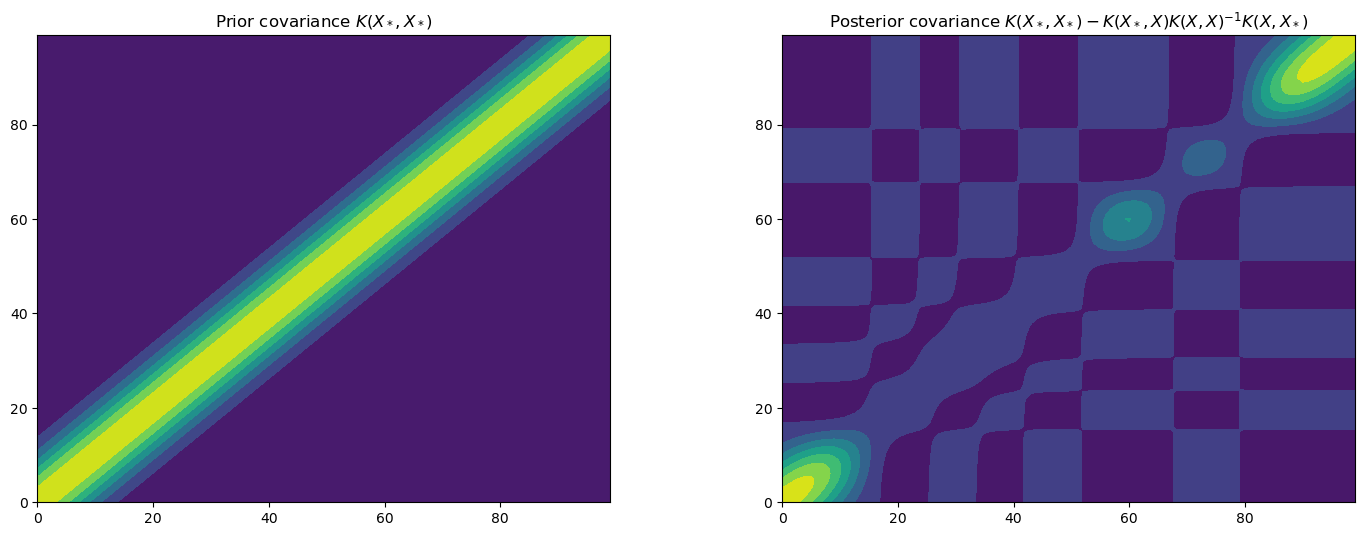

In [163]:
## kernel posterior
k_poster = var

#k_prior
k_prior = Kxx

fig = plt.figure(figsize=(17, 17))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.subplot(2, 2, 1)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(k_prior)

#visualize the covariance matrix
plt.subplot(2, 2, 2)
plt.title("Posterior covariance $K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*)$")
plt.contourf(k_poster)
plt.show()

In [191]:
# let define the log marginal likelihood

def neg_log_marginal_likelihood(hyp, *args):
    x, y, k, x_star = args
    
    sigma_f, sigma_n, length = hyp
    jitter = 1e-6
    N = x.shape[0]
    
    jitter = 1e-6
    K = k(x, x, length, sigma_f) + (sigma_n**2 + jitter) * np.eye(x.shape[0])
    Lxx = np.linalg.cholesky(K)    
    
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))

    log_det = 2 * np.sum(np.log(np.diag(Lxx)))
    
    lml = -0.5 * y.T @ a - 0.5 * log_det - 0.5 * N * np.log(2 * np.pi)

    return -lml 

In [211]:
neg_log_marginal_likelihood([1, 0.1, 1], x_train, y_train, square_exp_kernel, x_star)

array([[5.91039297]])

In [193]:
# optimize
from scipy.optimize import minimize

bounds = [[0, np.inf], [0.0001, np.inf], [0, np.inf]]

init_params = [1, 0.1, 1]

args = (x_train, y_train, square_exp_kernel, x_star)

# minimize the nlml
res = minimize(neg_log_marginal_likelihood, init_params, args=args, method='L-BFGS-B', bounds=bounds)

# extract the optimized parameters
sigma_f_opt, sigma_n_opt, lenth_opt = res.x

In [207]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.085965436858746
        x: [ 1.033e+00  7.512e-02  1.815e+00]
      nit: 10
      jac: [ 3.055e-05  4.327e-04 -2.487e-06]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [195]:
sigma_f_opt

1.0331212788618773

In [197]:
sigma_n_opt

0.07511512623526737

In [199]:
length

1

In [201]:
# inference with optimal value
mu_opt, var_opt = gp_inference_noise(x_train, y_train, square_exp_kernel, x_star, sigma_f_opt, sigma_n_opt, length)

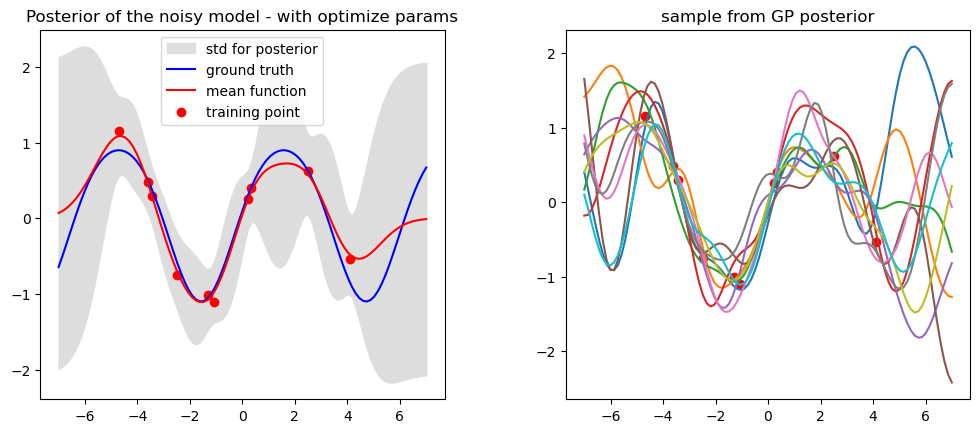

In [203]:
plot_posterior(x_train, y_train, x_star, mu_opt, var_opt, num_func=10, title="Posterior of the noisy model - with optimize params")

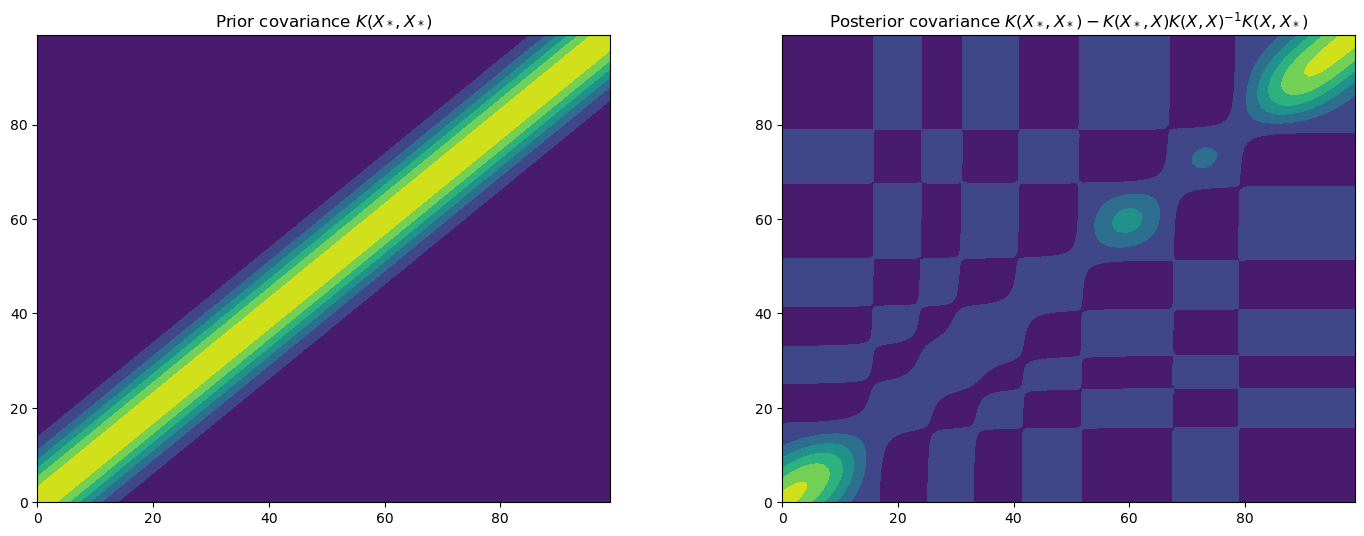

In [205]:
## kernel posterior
k_poster = var_opt

#k_prior
k_prior = Kxx

fig = plt.figure(figsize=(17, 17))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.subplot(2, 2, 1)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(k_prior)

#visualize the covariance matrix
plt.subplot(2, 2, 2)
plt.title("Posterior covariance $K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*)$")
plt.contourf(k_poster)
plt.show()